<a target="_blank" href="https://colab.research.google.com/github/arindamchoudhury/ml-projects/blob/main/MNIST_Handwritten_Digits.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction

In this project, we will build a neural network of to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)



## Imports

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import multiprocessing

In [46]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Load the Dataset

In [47]:
# Define transforms
# https://nextjournal.com/gkoehler/pytorch-mnist Normalize params 
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,))
            ])

# Create training set and define training dataloader
training_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

## Let's keep 80% of the training data for training
train_len = int(len(training_dataset) * 0.8)

## Let's use the remaining for validation
val_len = len(training_dataset) - train_len

train_dataset, valid_dataset = torch.utils.data.random_split(training_dataset, [train_len, val_len])

# Create test set and define test dataloader
batch_size = 64
num_workers = multiprocessing.cpu_count()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

## Explore the Dataset


In [48]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

5


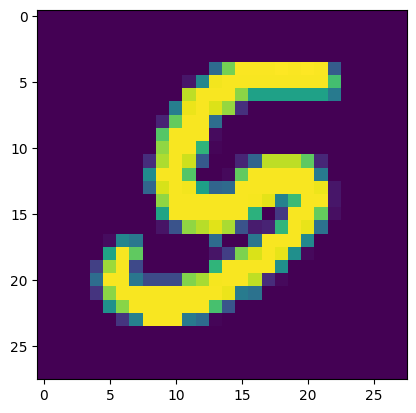

7


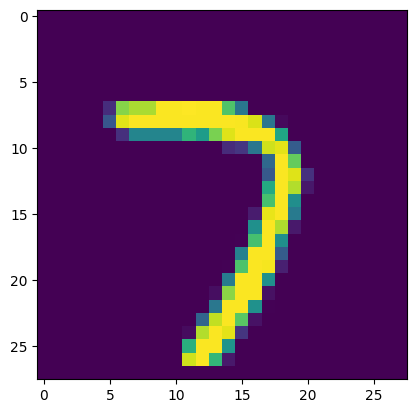

5


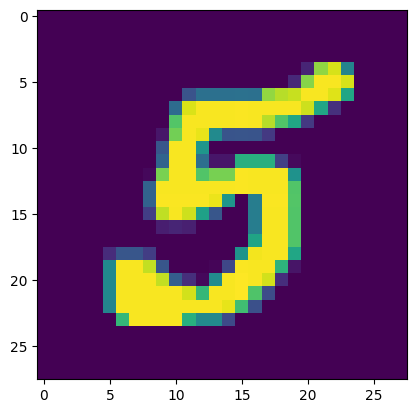

3


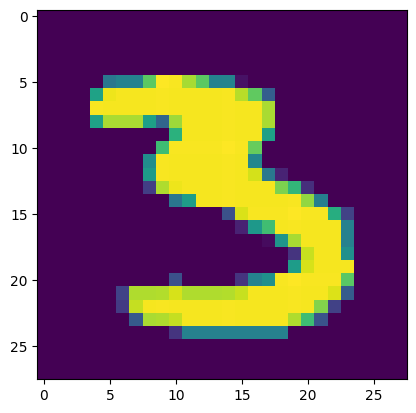

0


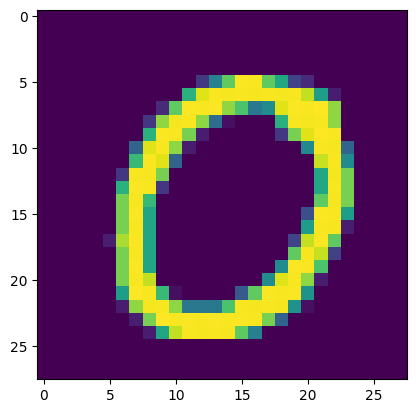

In [49]:
# Explore data
show5(train_loader)

## Build the Model

In [50]:
# base of the LeNet5 collected from https://github.com/rgkannan676/MNIST-Handwritten-Digit-Recognition/blob/main/OptmizerSelection.py
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv2_bn = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.relu3 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(120)
        
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.relu4 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(84)
        
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        torch.nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')        
        self.relu5 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv1_bn(out)
        out = self.relu1(out)
        out = self.pool1(out)
        
        out = self.conv2(out)
        out = self.conv2_bn(out)
        out = self.relu2(out)
        out = self.pool2(out)

        out = out.view(-1,16*5*5)

        out = self.fc1(out)
        out = self.relu3(out)
        out = self.bn1(out)

        out = self.fc2(out)
        out = self.relu4(out)
        out = self.bn2(out)

        out = self.fc3(out)
        return out
    
net = LeNet5()
net.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu5): ReLU()
)

In [51]:
scripted = torch.jit.script(net)
torch.jit.save(scripted, "visualize_model.pt")
# open in neutron.app to visualize the model

## Running the Model

In [52]:
def accuracy(logits, labels):
    _, yhat = torch.max(logits.data, dim=1)
    equals = yhat == labels
    return torch.mean(equals.type(torch.FloatTensor))

In [53]:
# collected from https://www.coursera.org/projects/pneumonia-classification-using-pytorch
class ModelTrainer():
    def __init__(self, criterion = None, optimizer = None):        
        self.criterion = criterion
        self.optimizer = optimizer
  
    def train_batch_loop(self, model, trainloader):        
        train_loss = 0.0
        train_acc = 0.0
        
        for data, labels in tqdm(trainloader, desc="Training", total=len(train_loader), leave=True):            
            data = data.to(device)
            labels = labels.to(device)
            
            self.optimizer.zero_grad()
            logits = model(data)
            loss = self.criterion(logits, labels)
                        
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            train_acc += accuracy(logits, labels)
            
        return train_loss / len(trainloader.dataset), train_acc / len(trainloader) 

    
    def valid_batch_loop(self, model, validloader):        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for data, labels in tqdm(validloader, desc="Validating", total=len(validloader), leave=True):                
            data = data.to(device)
            labels = labels.to(device)
             
            logits = model(data)
            loss = self.criterion(logits, labels)
              
            valid_loss += loss.item() * data.size(0)
            valid_acc += accuracy(logits, labels)
            
        return valid_loss / len(validloader.dataset), valid_acc / len(validloader)
            
        
    def fit(self, model, trainloader, validloader, epochs, filename):        
        valid_min_loss = np.Inf
        train_loss_history = list()
        valid_loss_history = list()
        
        for i in range(epochs):            
            model.train()
            avg_train_loss, avg_train_acc = self.train_batch_loop(model, trainloader)
            train_loss_history.append(avg_train_loss)
            
            model.eval()
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model, validloader)
            valid_loss_history.append(avg_valid_loss)
            
            if avg_valid_loss < valid_min_loss:
                print(f"validation loss decreased {valid_min_loss} --> {avg_valid_loss}")
                torch.save(model.state_dict(), filename)
                valid_min_loss = avg_valid_loss

                
            print(f"Epoch : {i+1} Train Loss : {avg_train_loss:.6f} Train Acc : {avg_train_acc:.6f}")
            print(f"Epoch : {i+1} Valid Loss : {avg_valid_loss:.6f} Valid Acc : {avg_valid_acc:.6f} Min Loss : {valid_min_loss:.6f}")
        
        return train_loss_history, valid_loss_history

In [54]:
optimizer =  optim.Adam(net.parameters(), lr=0.003, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

trainer = ModelTrainer(criterion, optimizer)
train_loss_history, valid_loss_history = trainer.fit(model=net, trainloader=train_loader, validloader=valid_loader, epochs=20, filename="leNet.pt")

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

validation loss decreased inf --> 0.7102702684402465
Epoch : 1 Train Loss : 0.511383 Train Acc : 0.940521
Epoch : 1 Valid Loss : 0.710270 Valid Acc : 0.919049 Min Loss : 0.710270


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

validation loss decreased 0.7102702684402465 --> 0.49052155447006224
Epoch : 2 Train Loss : 0.544869 Train Acc : 0.958604
Epoch : 2 Valid Loss : 0.490522 Valid Acc : 0.942819 Min Loss : 0.490522


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

validation loss decreased 0.49052155447006224 --> 0.4516012150446574
Epoch : 3 Train Loss : 0.531065 Train Acc : 0.960271
Epoch : 3 Valid Loss : 0.451601 Valid Acc : 0.961519 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.525847 Train Acc : 0.960187
Epoch : 4 Valid Loss : 0.497977 Valid Acc : 0.957114 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.516747 Train Acc : 0.961458
Epoch : 5 Valid Loss : 0.542839 Valid Acc : 0.964594 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.513442 Train Acc : 0.960833
Epoch : 6 Valid Loss : 0.510939 Valid Acc : 0.957696 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.514985 Train Acc : 0.960333
Epoch : 7 Valid Loss : 0.528536 Valid Acc : 0.949385 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.510317 Train Acc : 0.961312
Epoch : 8 Valid Loss : 0.562896 Valid Acc : 0.953541 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.510685 Train Acc : 0.961104
Epoch : 9 Valid Loss : 0.536087 Valid Acc : 0.962350 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.512173 Train Acc : 0.960354
Epoch : 10 Valid Loss : 0.522933 Valid Acc : 0.962683 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.507114 Train Acc : 0.961479
Epoch : 11 Valid Loss : 0.467725 Valid Acc : 0.973238 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 12 Train Loss : 0.504630 Train Acc : 0.963083
Epoch : 12 Valid Loss : 0.529563 Valid Acc : 0.967753 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.508818 Train Acc : 0.961312
Epoch : 13 Valid Loss : 0.503018 Valid Acc : 0.952876 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.508705 Train Acc : 0.962208
Epoch : 14 Valid Loss : 0.539299 Valid Acc : 0.958361 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.507513 Train Acc : 0.961396
Epoch : 15 Valid Loss : 0.526235 Valid Acc : 0.953457 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.505687 Train Acc : 0.962333
Epoch : 16 Valid Loss : 0.514826 Valid Acc : 0.956865 Min Loss : 0.451601


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

validation loss decreased 0.4516012150446574 --> 0.4427121075789134
Epoch : 17 Train Loss : 0.508792 Train Acc : 0.960167
Epoch : 17 Valid Loss : 0.442712 Valid Acc : 0.969830 Min Loss : 0.442712


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.507382 Train Acc : 0.961000
Epoch : 18 Valid Loss : 0.483733 Valid Acc : 0.960938 Min Loss : 0.442712


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.506497 Train Acc : 0.961375
Epoch : 19 Valid Loss : 0.647457 Valid Acc : 0.933428 Min Loss : 0.442712


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 20 Train Loss : 0.509076 Train Acc : 0.960375
Epoch : 20 Valid Loss : 0.497438 Valid Acc : 0.951213 Min Loss : 0.442712


Plot the training loss and validation loss/accuracy:

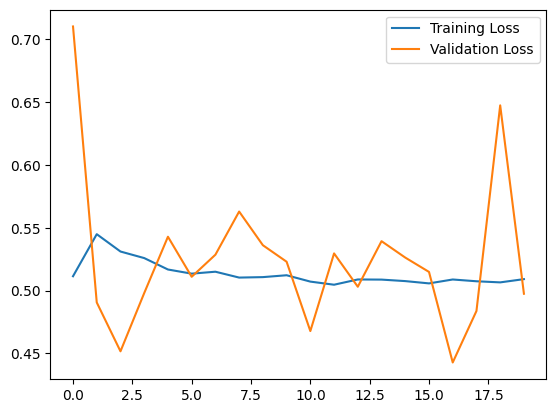

In [55]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(valid_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing the model


In [56]:
test_net = LeNet5()
test_net.to(device)
test_net.load_state_dict(torch.load('leNet.pt'))
test_net.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(test_net, test_loader)


print("Test Loss : {}".format(avg_test_loss))
print("Test Acc : {}".format(avg_test_acc))

Validating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss : 0.44272942657470704
Test Acc : 0.9705414175987244


## Saving model

In [57]:
torch.save(net.state_dict(), "LeNetFinal.pt")